# Basic Spectrum Generation

The first and most simple way in which TARDIS calculates spectra is by calculating it directly from the Monte Carlo packets after the final [Monte Carlo Iteration](../montecarlo/index.rst). This simply requires knowledge of each packet's energy and frequency in the lab frame (see [Reference Frames](../montecarlo/propagation.rst#reference-frames)) at the end of the iteration. The only other quantity needed is the time duration of the simulation $\Delta t$, which is calculated based off of the luminosity of the supernova's photosphere (see [Energy Packet Initialization](../montecarlo/initialization.ipynb)).

<div class="alert alert-info">

Note

The only packets which are used for this calculation are the packets which escape the outer boundary of the
computational domain -- those reabsorbed into the photosphere are not included (see [Packet Propagation](../montecarlo/propagation.rst)).

</div>

The spectrum calculation is very straightforward. A packet of energy $E_\mathrm{packet}$ contributes a
luminosity

$$L_\mathrm{packet} = \frac{E_\mathrm{packet}}{\Delta t}$$

to the spectrum at its frequency.

In the code below, we will see an issue with merely relying on luminosity to give us a spectrum, which will allow us to develop the concept of luminosity *density*, and then correctly plot the TARDIS spectrum.

We start by importing the necessary packages, loading a configuration, and setting up a simulation object (see [Setting up the Simulation](../setup/index.rst)):

In [1]:
from tardis.io.config_reader import Configuration
from tardis.simulation import Simulation
from tardis.montecarlo import TARDISSpectrum
from tardis.io.atom_data.util import download_atom_data
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

/usr/share/miniconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

/usr/share/miniconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


/usr/share/miniconda3/envs/tardis/lib/python3.7/site-packages/traitlets/traitlets.py:3050: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,


In [2]:
# We download the atomic data needed to run the simulation
download_atom_data('kurucz_cd23_chianti_H_He')

In [3]:
tardis_config = Configuration.from_yaml('tardis_example.yml')

sim = Simulation.from_config(tardis_config)

/usr/share/miniconda3/envs/tardis/lib/python3.7/site-packages/tardis-2021.11.23.0.dev102+g164d4412-py3.7.egg/tardis/plasma/properties/radiative_properties.py:92: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)


/usr/share/miniconda3/envs/tardis/lib/python3.7/site-packages/tardis-2021.11.23.0.dev102+g164d4412-py3.7.egg/tardis/plasma/properties/radiative_properties.py:92: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)


We now select a number of packets to run through the Monte Carlo simulation, and then run one Monte Carlo iteration (see [Monte Carlo Iteration](../montecarlo/index.rst)):

In [4]:
N_packets = 5000

# Using the commented out code below, we can also get the number of packets
# from the configuration -- try it out:
#N_packets = tardis_config.no_of_packets

sim.iterate(N_packets)

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

We call the arrays of each packet's frequency and how much energy the packet has:

In [5]:
nus = sim.runner.output_nu
nus

<Quantity [9.11729738e+14, 1.64488020e+14, 4.22176797e+14, ...,
           1.19556017e+15, 9.11110616e+14, 4.66280303e+14] Hz>

In [6]:
energies = sim.runner.output_energy
energies

<Quantity [ 0.00019893, -0.00019295,  0.00020609, ...,  0.00020733,
            0.00020628,  0.00019003] erg>

Notice that some energies are negative. This means that the packet ended up being reabsorbed into the photosphere (we will separate out these packets later). Also note that the number of elements of our arrays of frequencies and energies is the same as the number of packets that we ran (as it should be):

In [7]:
len(nus), len(energies)

(5000, 5000)

TARDIS will then calculate a list of the packet luminosities by dividing each element in the array of energies by the time of the simulation $\Delta t$:

In [8]:
luminosities = energies / sim.runner.time_of_simulation
luminosities

<Quantity [ 2.10726535e+39, -2.04384013e+39,  2.18311529e+39, ...,
            2.19620660e+39,  2.18508231e+39,  2.01288991e+39] erg / s>

Now, as mentioned before, we only want to include the packets that make it through to the outer boundary. To do this, TARDIS creates an array of booleans (either True or False) called a mask that tells us if the packet should be counted in the spectrum. We then can use that mask to get an array of the frequencies and energies of only the packets which we are interested in:

In [9]:
emitted_mask = sim.runner.emitted_packet_mask
emitted_mask

array([ True, False,  True, ...,  True,  True,  True])

In [10]:
emitted_nus = nus[emitted_mask]
emitted_nus

<Quantity [9.11729738e+14, 4.22176797e+14, 5.69125545e+14, ...,
           1.19556017e+15, 9.11110616e+14, 4.66280303e+14] Hz>

In [11]:
emitted_luminosities = luminosities[emitted_mask]
emitted_luminosities

<Quantity [2.10726535e+39, 2.18311529e+39, 2.16484616e+39, ...,
           2.19620660e+39, 2.18508231e+39, 2.01288991e+39] erg / s>

The length of these lists is the number of packets that made it out of the supernova:

In [12]:
len(emitted_nus), len(emitted_luminosities)

(3680, 3680)

Now, let's plot frequency versus luminosity. We will see a very strange graph, which will lead us into developing a new strategy for plotting the spectrum:

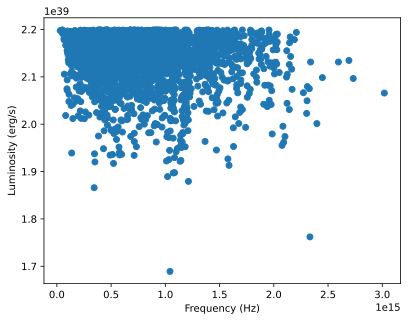

In [13]:
plt.scatter(emitted_nus, emitted_luminosities)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Luminosity (erg/s)');

This is not the type of plot that we are looking for. We also cannot solve this problem by adding up the luminosities of all packets with the same frequency -- in fact, since frequency is a continuum, it would be extremely unlikely that any two packets have the same *exact* frequency. To solve this problem, we will need the concept of luminosity density.

## Luminosity Density

What we will have to do instead is plot a histogram where we bin up different frequencies that are close to each other into a certain number of bins. We then add up the luminosities of each packet in the bin and divide by the "width" of the bins. For example, if we are plotting between 0 Hz and 50 Hz in 5 bins, we would add up the luminosities of the packets between 0 Hz and 10 Hz, between 10 Hz and 20 Hz, between 20 Hz and 30 Hz, etc., and then divide each value by 10 Hz, which is the width of each bin (note that the bin widths need not be uniform). This will give us the luminosity density with respect to frequency, denoted by $L_\nu$, and measured in ergs per second per Hertz. This can be interpreted as the luminosity per unit Hertz, i.e. how much luminosity will be in an interval with a width of 1 Hz.

The division step here is crucial, as otherwise the values on the y-axis will, for example, approximately double if we double the widths of our bins (as we would be adding about double the luminosity contributions into that bin). We clearly want the values on the y-axis to be independent of the number of bins we break the luminosity into, thus making luminosity density the best way to plot a spectrum.

Note that we can also have luminosity density with respect to wavelength, $L_\lambda$, which we get by binning the packets by wavelength instead of frequency. Since the width of the bins would now have the dimensions of length, $L_\lambda$ will have units of ergs per second per Angstrom.

Now, to generate our spectrum, we select the bounds for our spectrum and the number of bins that we group the packets into. Feel free to change the number of bins to see how it affects the spectrum!

In [14]:
# The lowest frequency we plot
freq_start = 1.5e14 * u.Hz

# The highest frequency we plot
freq_stop = 3e15 * u.Hz

# The number of bins
N = 500

The above information can also be retrieved from the configuration using the commented-out code below. Note that the configuration has the bounds specified in terms of wavelengths. Therefore we must convert these to frequencies, noting that the frequency is the speed of light divided by the wavelength (Astropy has a built-in way to do this, which we shall use). Additionally, since wavelength and frequency are inversely related, the lower bound for the wavelengths is the upper bound for the frequencies and vice versa.

In [15]:
#freq_start = tardis_config.spectrum.stop.to('Hz', u.spectral())

#freq_stop = tardis_config.spectrum.start.to('Hz', u.spectral())

#N = tardis_config.spectrum.num

Next, TARDIS generates the list of frequency bins. The array shown contain the boundaries between successive bins as well as the lower and upper bounds of the spectrum:

In [16]:
spectrum_frequency = np.linspace(freq_start, freq_stop, N+1)
spectrum_frequency

<Quantity [1.5000e+14, 1.5570e+14, 1.6140e+14, 1.6710e+14, 1.7280e+14,
           1.7850e+14, 1.8420e+14, 1.8990e+14, 1.9560e+14, 2.0130e+14,
           2.0700e+14, 2.1270e+14, 2.1840e+14, 2.2410e+14, 2.2980e+14,
           2.3550e+14, 2.4120e+14, 2.4690e+14, 2.5260e+14, 2.5830e+14,
           2.6400e+14, 2.6970e+14, 2.7540e+14, 2.8110e+14, 2.8680e+14,
           2.9250e+14, 2.9820e+14, 3.0390e+14, 3.0960e+14, 3.1530e+14,
           3.2100e+14, 3.2670e+14, 3.3240e+14, 3.3810e+14, 3.4380e+14,
           3.4950e+14, 3.5520e+14, 3.6090e+14, 3.6660e+14, 3.7230e+14,
           3.7800e+14, 3.8370e+14, 3.8940e+14, 3.9510e+14, 4.0080e+14,
           4.0650e+14, 4.1220e+14, 4.1790e+14, 4.2360e+14, 4.2930e+14,
           4.3500e+14, 4.4070e+14, 4.4640e+14, 4.5210e+14, 4.5780e+14,
           4.6350e+14, 4.6920e+14, 4.7490e+14, 4.8060e+14, 4.8630e+14,
           4.9200e+14, 4.9770e+14, 5.0340e+14, 5.0910e+14, 5.1480e+14,
           5.2050e+14, 5.2620e+14, 5.3190e+14, 5.3760e+14, 5.4330e+14,
      

Then, TARDIS creates a histogram where we add up the luminosity in each bin:

In [17]:
emitted_luminosity_hist = u.Quantity(np.histogram(emitted_nus,
                                                  weights=emitted_luminosities,
                                                  bins=spectrum_frequency.value,
                                                 )[0], "erg / s",)
emitted_luminosity_hist

<Quantity [8.67127725e+39, 1.29469584e+40, 1.50221432e+40, 1.29918070e+40,
           1.08636532e+40, 1.92410689e+40, 2.15935204e+40, 3.02400066e+40,
           2.57886694e+40, 1.50653331e+40, 2.37393408e+40, 3.23567752e+40,
           3.44721683e+40, 3.22909474e+40, 1.52056674e+40, 2.36739637e+40,
           1.71525793e+40, 2.79988304e+40, 2.36836256e+40, 3.87883176e+40,
           4.11203950e+40, 3.03669083e+40, 2.57531856e+40, 2.38530607e+40,
           3.02593320e+40, 3.45323467e+40, 4.53866277e+40, 4.76427541e+40,
           3.45514168e+40, 3.44813815e+40, 2.81434534e+40, 3.23149780e+40,
           2.82661926e+40, 3.88242949e+40, 3.61083437e+40, 4.30904147e+40,
           4.10607734e+40, 3.63013072e+40, 4.99036180e+40, 4.09496206e+40,
           3.45459471e+40, 3.87116999e+40, 2.58068381e+40, 3.67509119e+40,
           4.08414417e+40, 4.73298110e+40, 4.08041716e+40, 3.87844888e+40,
           4.07278208e+40, 5.35231439e+40, 4.73980632e+40, 5.98704549e+40,
           4.54547441e+40

Finally, we input this information into the TARDISSpectrum class, which will generate the luminosity density with respect to both wavelength and frequency and allow us to plot both of these.

In [18]:
spectrum = TARDISSpectrum(spectrum_frequency, emitted_luminosity_hist)

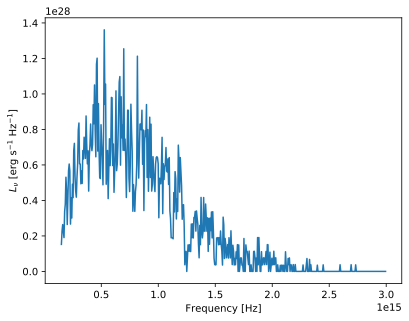

In [19]:
spectrum.plot(mode='frequency')

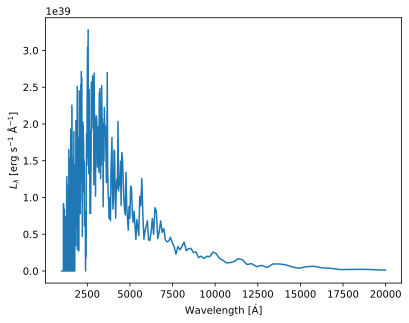

In [20]:
spectrum.plot(mode='wavelength')

<div class="alert alert-info">

Note

Most of this process is done internally by TARDIS. Given a simulation object `sim` that has been run, calling `sim.runner.spectrum` will give you a `TARDISSpectrum` object that can then be plotted using the `.plot()` method. See, for example, our [Quickstart Guide](../../quickstart/quickstart.ipynb). This notebook just demonstrates how TARDIS generates this spectrum when `sim.runner.spectrum` is called.

</div>

You may notice that the bins are not uniformly spaced with respect to wavelength. This is because we use the same bins for both wavelength and frequency, and thus the bins which are uniformly spaced with respect to frequency are not uniformly spaced with respect to wavelength. This is okay though, since luminosity density allows us to alter the bins without significantly altering the graph!

Another thing you may notice in these graphs is the lack of a smooth curve. This is due to **noise**: the effects of the random nature of Monte Carlo simulations. This makes it very difficult to get a precise spectrum without drastically increasing the number of Monte Carlo packets. To solve this problem, TARDIS uses [virtual packets](virtualpackets.rst) and [the formal integral method](sourceintegration.rst) to generate a spectrum with less noise.